In [ ]:
!pip install torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float32)

In [ ]:
x_min, x_max = -1.0, 1.0
t_min, t_max = 0.0, 1.0
nu = 0.01 / np.pi

N_f = 10000
N_0 = 200
N_b = 200

X_f = np.random.rand(N_f, 2)
X_f[:, 0] = X_f[:, 0] * (x_max - x_min) + x_min  # x in [-1, 1]
X_f[:, 1] = X_f[:, 1] * (t_max - t_min) + t_min    # t in [0, 1]

x0 = np.linspace(x_min, x_max, N_0)[:, None]
t0 = np.zeros_like(x0)
u0 = -np.sin(np.pi * x0)

tb = np.linspace(t_min, t_max, N_b)[:, None]
xb_left = np.ones_like(tb) * x_min
xb_right = np.ones_like(tb) * x_max
ub_left = np.zeros_like(tb)
ub_right = np.zeros_like(tb)

X_f = torch.tensor(X_f, dtype=torch.float32, requires_grad=True)
x0 = torch.tensor(x0, dtype=torch.float32)
t0 = torch.tensor(t0, dtype=torch.float32)
u0 = torch.tensor(u0, dtype=torch.float32)
tb = torch.tensor(tb, dtype=torch.float32)
xb_left = torch.tensor(xb_left, dtype=torch.float32)
xb_right = torch.tensor(xb_right, dtype=torch.float32)
ub_left = torch.tensor(ub_left, dtype=torch.float32)
ub_right = torch.tensor(ub_right, dtype=torch.float32)

In [ ]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()

        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
        self.layers = nn.ModuleList(layer_list)

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
        return self.layers[-1](x)

layers = [2, 50, 50, 50, 50, 1]
model = PINN(layers)
print(model)

PINN(
  (activation): Tanh()
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

PINN(
  (activation): Tanh()
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [ ]:
def pde_residual(model, X):
    x = X[:, 0:1]
    t = X[:, 1:2]
    u = model(torch.cat([x, t], dim=1))

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]

    f = u_t + u * u_x - nu * u_xx
    return f

def loss_func(model):
    f_pred = pde_residual(model, X_f.to(device))
    loss_f = torch.mean(f_pred**2)

    u0_pred = model(torch.cat([x0.to(device), t0.to(device)], dim=1))
    loss_0 = torch.mean((u0_pred - u0.to(device))**2)

    u_left_pred = model(torch.cat([xb_left.to(device), tb.to(device)], dim=1))
    u_right_pred = model(torch.cat([xb_right.to(device), tb.to(device)], dim=1))
    loss_b = torch.mean(u_left_pred**2) + torch.mean(u_right_pred**2)

    loss = loss_f + loss_0 + loss_b
    return loss

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 5000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_func(model)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 500 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.5e}')

print("Training complete!")

Epoch 500/5000, Loss: 1.01492e-01
Epoch 1000/5000, Loss: 8.23593e-02
Epoch 1500/5000, Loss: 5.83175e-02
Epoch 2000/5000, Loss: 3.00659e-02
Epoch 2500/5000, Loss: 1.58814e-02
Epoch 3000/5000, Loss: 1.06935e-02
Epoch 3500/5000, Loss: 7.78412e-03
Epoch 4000/5000, Loss: 5.50484e-03
Epoch 4500/5000, Loss: 3.98181e-03
Epoch 5000/5000, Loss: 7.55987e-03
Training complete!


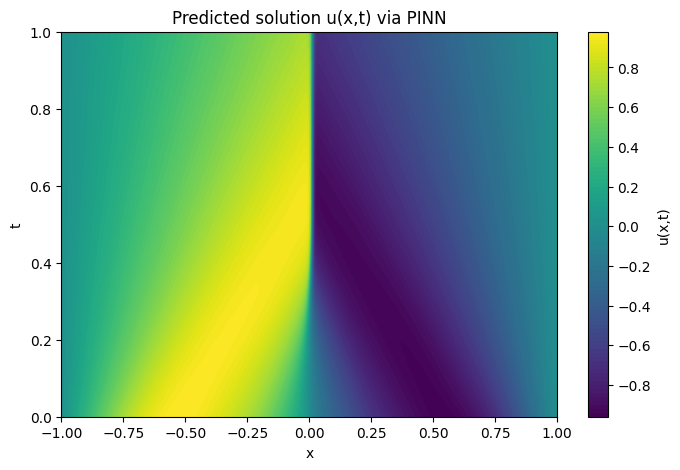

In [ ]:
N_x, N_t = 256, 100
x = np.linspace(x_min, x_max, N_x)
t = np.linspace(t_min, t_max, N_t)
X, T = np.meshgrid(x, t)
XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
XT_tensor = torch.tensor(XT, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    u_pred = model(XT_tensor).cpu().numpy().reshape(N_t, N_x)

plt.figure(figsize=(8, 5))
plt.contourf(X, T, u_pred, levels=100, cmap='viridis')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title("Predicted solution u(x,t) via PINN")
plt.show()